In [1]:
import pandas as pd
from urllib.parse import urlparse
import re
import ipaddress

# Load the dataset
df = pd.read_csv('urldata.csv')

# Inspect data
df.sample(100)

,Unnamed: 0,url,label,result
210229,210229,https://www.hiltonheadhomesandvillas.com/,benign,0
9587,9587,https://www.blog.us.playstation.com/2011/09/27...,benign,0
33368,33368,https://www.en.wikipedia.org/wiki/Film,benign,0
178602,178602,https://www.eforu.com/birthdays/1941.html,benign,0
341562,341562,https://www.mattmillersoccer.com/wpi/,benign,0
...,...,...,...,...
338565,338565,https://www.zionriverresort.com/,benign,0
124231,124231,https://www.360canaries.com/gran-canaria/gran-...,benign,0
159719,159719,https://www.cdbaby.com/style/9,benign,0
264086,264086,https://www.njcaa.org/colleges_college_player....,benign,0


In [2]:
# feature extraction preformed by URLFeatureExtraction.py
# python URLFeatureExtraction.py urldata.csv returns featuredata.csv
df = pd.read_csv('featuredata.csv', on_bad_lines='skip')

features = ['Have_IP', 'Have_At', 'URL_Length', 'URL_Depth','Redirection', 
                        'https_Domain', 'TinyURL', 'Prefix/Suffix', 'DNS_Record',
                        'Domain_Age', 'Domain_End', 'iFrame', 'Mouse_Over','Right_Click', 'Web_Forwards']


In [3]:
# Convert the features into separate columns
# df_features = pd.DataFrame(df['features'].tolist(), index=df.index, columns=features)

# Combine the extracted features with the original DataFrame
# df_combined = pd.concat([df, df_features], axis=1)
df = df.dropna(subset=['Label'])


In [4]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


# Define X (features) and y (target)
X = df[features]
y = df['Label']

# Step 1: Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Use SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Step 3: Train the model on the resampled data
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Step 4: Make predictions on the test set
y_pred = rf_model.predict(X_test)



In [5]:
# Feature extracted URLs tested
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Step 4: Train the model
history = model.fit(X_train_resampled, y_train_resampled, epochs=2, batch_size=128, validation_data=(X_test, y_test))

# Step 5: Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')



c:\Users\kesha\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/2
308/308 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6410 - loss: 0.6285 - val_accuracy: 0.7436 - val_loss: 0.5264
Epoch 2/2
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7258 - loss: 0.5406 - val_accuracy: 0.7478 - val_loss: 0.5115
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7509 - loss: 0.5106
Test Accuracy: 0.7477741241455078


In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Bidirectional, LSTM
from tensorflow.keras.optimizers import Adam

# Step 1: Prepare the data (0 for benign, 1 for phishing)

# Tokenize the URLs (character-level tokenization)
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(df['URL'])

# Convert the URLs into sequences of integers
url_sequences = tokenizer.texts_to_sequences(df['URL'])

# Pad the sequences to make them of equal length
max_sequence_length = 100  # can be adjusted based on data
X = pad_sequences(url_sequences, maxlen=max_sequence_length)

# Target labels
y = df['Label'].values

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Build the LSTM model
vocab_size = len(tokenizer.word_index) + 1  # Total number of unique characters
embedding_dim = 50  # Size of the character embedding vectors

model = Sequential()
# Embedding layer (convert each character to a dense vector)
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
# LSTM layer
model.add(Bidirectional(LSTM(128, return_sequences=False)))
# Output layer (binary classification)
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Step 4: Train the model
model.fit(X_train, y_train, epochs=1, batch_size=128, validation_data=(X_test, y_test))

# Step 5: Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy Bi: {accuracy}')

278/278 ━━━━━━━━━━━━━━━━━━━━ 137s 445ms/step - accuracy: 0.7921 - loss: 0.4077 - val_accuracy: 0.9802 - val_loss: 0.0649
278/278 ━━━━━━━━━━━━━━━━━━━━ 16s 57ms/step - accuracy: 0.9815 - loss: 0.0627
Test Accuracy Bi: 0.9801645278930664


Epoch 1/10
888/888 ━━━━━━━━━━━━━━━━━━━━ 126s 142ms/step - accuracy: 0.9703 - loss: 0.1092 - val_accuracy: 0.9476 - val_loss: 0.1726
Epoch 2/10
888/888 ━━━━━━━━━━━━━━━━━━━━ 133s 150ms/step - accuracy: 0.9277 - loss: 0.1934 - val_accuracy: 0.9708 - val_loss: 0.0860
Epoch 3/10
888/888 ━━━━━━━━━━━━━━━━━━━━ 192s 206ms/step - accuracy: 0.9685 - loss: 0.0890 - val_accuracy: 0.9869 - val_loss: 0.0414
Epoch 4/10
888/888 ━━━━━━━━━━━━━━━━━━━━ 213s 218ms/step - accuracy: 0.9856 - loss: 0.0420 - val_accuracy: 0.9901 - val_loss: 0.0300
Epoch 5/10
888/888 ━━━━━━━━━━━━━━━━━━━━ 213s 230ms/step - accuracy: 0.9698 - loss: 0.0992 - val_accuracy: 0.9915 - val_loss: 0.0279
Epoch 6/10
888/888 ━━━━━━━━━━━━━━━━━━━━ 285s 256ms/step - accuracy: 0.9917 - loss: 0.0267 - val_accuracy: 0.9932 - val_loss: 0.0242
Epoch 7/10
888/888 ━━━━━━━━━━━━━━━━━━━━ 255s 287ms/step - accuracy: 0.9935 - loss: 0.0209 - val_accuracy: 0.9928 - val_loss: 0.0221
Epoch 8/10
888/888 ━━━━━━━━━━━━━━━━━━━━ 198s 223ms/step - accuracy: 0.9935 -

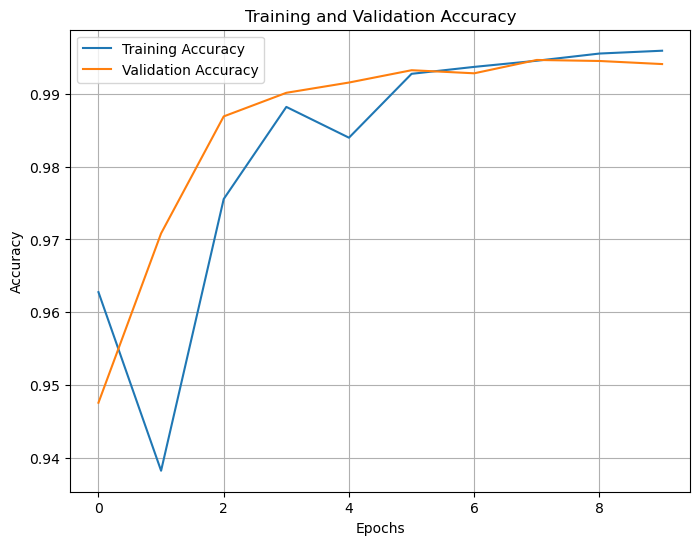

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
history = model.fit(
    X_train, y_train, 
    validation_split=0.2,  # Use 20% of the training data for validation
    epochs=10, 
    batch_size=32
)

def plot_training_history(history):
    plt.figure(figsize=(8, 6))
    
    # Plot the accuracy
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    
    # Add labels and legend
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage: assuming you have a 'history' object
plot_training_history(history)


278/278 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step


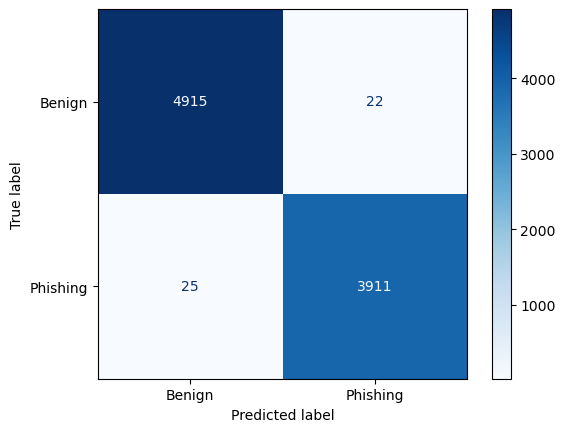

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# step 1: make predictions on test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# step 2: gererate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# step 3: display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign","Phishing"])
disp.plot(cmap="Blues", values_format='d')